# Results

In [1]:
experiment_name = "l1000_env_prior_VAE"
exp_id = 1

## Loading

In [2]:
import numpy as np
from scipy.spatial.distance import cosine
from scipy.linalg import svd, inv
import pandas as pd
import matplotlib.pyplot as plt
import dill as pickle
import os
import pdb
import torch
import ai.causalcell
from ai.causalcell.training import set_seed
from ai.causalcell.utils import configuration
os.chdir(os.path.join(os.path.dirname(ai.__file__), ".."))
print("Working in", os.getcwd())    

Working in /Users/paul/PycharmProjects/causal_cell_embedding


In [3]:
def load_all_losses(name='recon_loss'):
    all_train_loss = []
    for epoch in range(len(results['losses']['train'])):
        train_loss = np.mean([results['losses']['train'][epoch][i][name]
        for i in range(len(results['losses']['train'][epoch]))])
        all_train_loss.append(train_loss)
    all_valid_loss = []
    for epoch in range(len(results['losses']['valid'])):
        valid_loss = np.mean([results['losses']['valid'][epoch][i][name]
        for i in range(len(results['losses']['valid'][epoch]))])
        all_valid_loss.append(valid_loss)
    return all_train_loss, all_valid_loss

In [4]:
result_dir = os.path.join(os.getcwd(), "results", experiment_name)

In [5]:
with open(os.path.join(result_dir,'results_' 
          + str(exp_id) + '.pkl'), 'rb') as f:
    results = pickle.load(f)

In [6]:
results.keys()

dict_keys(['exp_name', 'config', 'data_graph', 'seed', 'exp_id', 'n_envs_in_split', 'n_samples_in_split', 'losses', 'best_epoch'])

In [7]:
model_name = list(results['config']['model'].keys())[0]

In [8]:
if results['data_graph'] is not None:
    plt.figure(figsize=(7, 5), dpi=200)
    results['data_graph'].draw()
    plt.show()

In [9]:
# results['data_graph'].graph.nodes[4]

In [10]:
# n_observations = results['data_graph'].n_observations
# n_hidden = results['data_graph'].n_hidden

## Experiment configuration

In [11]:
results['config']

{'cuda': True,
 'seed': 1,
 'optimizer': {'Adam': {'lr': 0.0001}},
 'batch_size': 32,
 'n_epochs': 200,
 'generic': {'exp_id': [1, 2, 3], 'seed': [1, 2, 3]},
 'exp_id': 1,
 'early_stopping': True,
 'patience_max': 5,
 'dataset': {'train': {'L1000_iid_env_split': {'phase': 'both',
    'batch_size': 32,
    'radius': 4,
    'nBits': 1024,
    'train_val_test_prop': (0.7, 0.2, 0.1)}},
  'valid': {'L1000_iid_env_split': {'phase': 'both',
    'batch_size': 32,
    'radius': 4,
    'nBits': 1024,
    'train_val_test_prop': (0.7, 0.2, 0.1)}}},
 'model': {'env_prior_VAE': {'enc_layers': [978, 500, 300],
   'dec_layers': [300, 500, 978],
   'aux_layers': [1180, 500, 300],
   'beta': 1}},
 'experiment_name': 'l1000_env_prior_VAE'}

In [12]:
results['n_envs_in_split']

{'train': 88980, 'valid': 25516}

In [13]:
results['n_samples_in_split']

{'train': 231907, 'valid': 66191}

## Reconstruction loss

In [14]:
all_train_loss, all_valid_loss = load_all_losses(name='recon_loss')

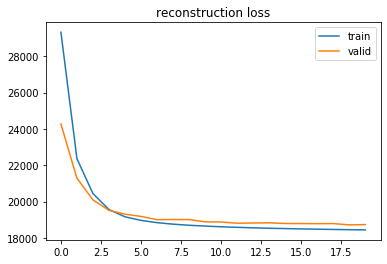

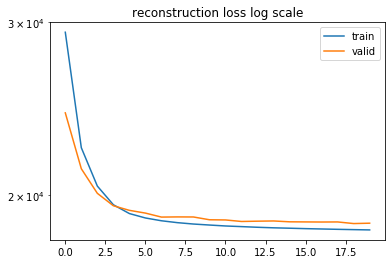

In [15]:
plt.plot(all_train_loss, label="train")
plt.plot(all_valid_loss, label="valid")
plt.title("reconstruction loss")
plt.legend()
plt.show()

plt.yscale("log")
plt.plot(all_train_loss, label="train")
plt.plot(all_valid_loss, label="valid")
plt.title("reconstruction loss log scale")
plt.legend()
plt.show()

## KL divergence loss

In [16]:
if 'kl_div' in results['losses']['train'][0][0].keys():
    all_train_loss, all_valid_loss = load_all_losses(name='kl_div')

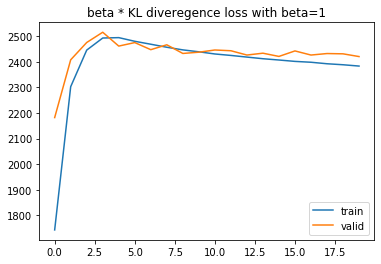

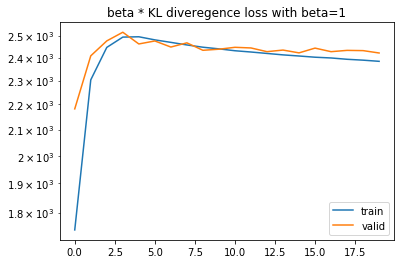

In [17]:
if 'kl_div' in results['losses']['train'][0][0].keys():
    plt.plot(all_train_loss, label="train")
    plt.plot(all_valid_loss, label="valid")
    if 'beta' in results['config']['model'][model_name].keys():
        plt.title("beta * KL diveregence loss with beta=" + str(results['config']['model'][model_name]['beta']))
    else:
        plt.title("KL diveregence loss")
    plt.legend()
    plt.show()
    
if 'kl_div' in results['losses']['train'][0][0].keys():
    plt.yscale("log")
    plt.plot(all_train_loss, label="train")
    plt.plot(all_valid_loss, label="valid")
    if 'beta' in results['config']['model'][model_name].keys():
        plt.title("beta * KL diveregence loss with beta=" + str(results['config']['model'][model_name]['beta']))
    else:
        plt.title("KL diveregence loss")
    plt.legend()
    plt.show()

## Activation statistics

In [18]:
set_seed(results['seed'])
# dataloader
valid_loader = configuration.setup_dataloader(results['config'], 'valid')
train_loader = configuration.setup_dataloader(results['config'], 'train')

pytorch/random seed: 1


RDKit WARNING: [08:42:00] Enabling RDKit 2019.09.3 jupyter extensions


Loading data of phase1
Loading data of phase2
valid split of size 66191 with number of environments 25516
Dataset already instanciated, loading it
train split of size 231907 with number of environments 88980


In [19]:
# print("training envs", np.unique(train_loader.dataset.envs, axis=0))
# print("valid_envs", np.unique(valid_loader.dataset.envs))

In [20]:
model = configuration.setup_model(results['config'])
model.load_state_dict(torch.load(os.path.join(result_dir, "last_model_" + str(exp_id) + ".pth.tar")))

<All keys matched successfully>

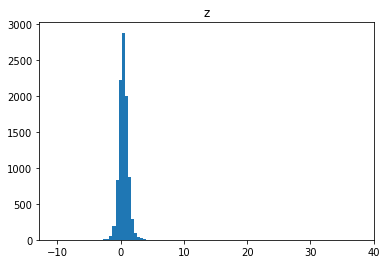

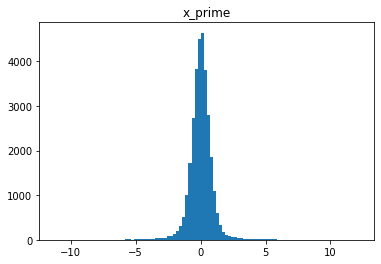

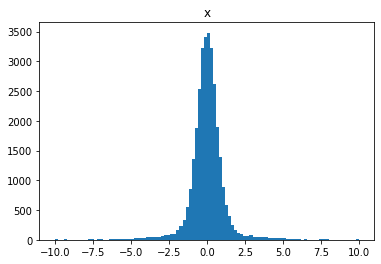

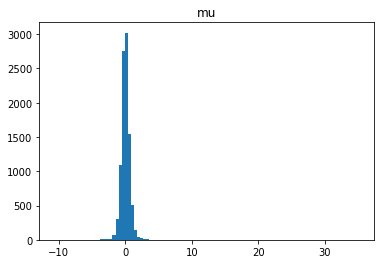

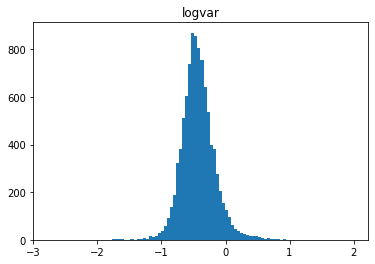

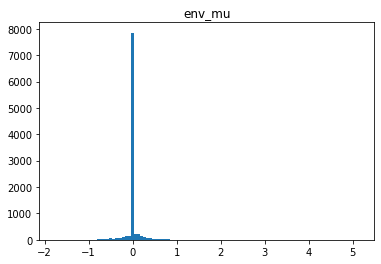

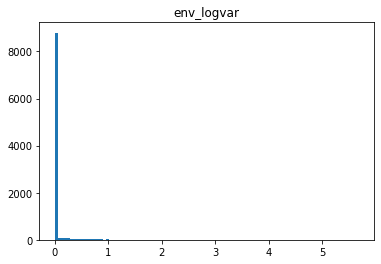

In [21]:
with torch.no_grad():
    for batch_idx, data in enumerate(valid_loader):

        x, fingerprint, compound, line = data

        # Expected to return a dictionary of outputs.
        outputs = model.forward(x, fingerprint, compound, line)
        for key in outputs.keys():
            plt.hist(outputs[key].numpy().reshape(-1), bins=100)
            plt.title(key)
            plt.show()
        break

torch.Size([32, 978])


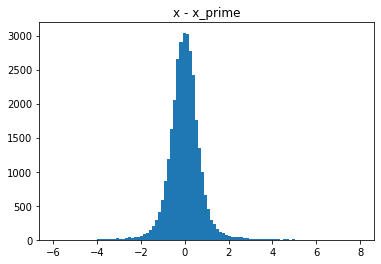

In [22]:
x_minus_x_prime = outputs['x'] - outputs['x_prime']
print(x_minus_x_prime.shape)
plt.hist(x_minus_x_prime.numpy().reshape(-1), bins=100)
plt.title('x - x_prime')
plt.show()

## Weights

In [31]:
model

VariationalAutoEncoder(
  (encoder): LinearLayers(
    (dropout): Dropout(p=0, inplace=False)
    (activation): ReLU()
    (model): Sequential(
      (0): Linear(in_features=10, out_features=5, bias=True)
      (1): ReLU()
    )
  )
  (mu): LinearLayers(
    (dropout): Dropout(p=0, inplace=False)
    (activation): ReLU()
    (model): Sequential(
      (0): Linear(in_features=5, out_features=2, bias=True)
    )
  )
  (logvar): LinearLayers(
    (dropout): Dropout(p=0, inplace=False)
    (activation): ReLU()
    (model): Sequential(
      (0): Linear(in_features=5, out_features=2, bias=True)
    )
  )
  (decoder): LinearLayers(
    (dropout): Dropout(p=0, inplace=False)
    (activation): ReLU()
    (model): Sequential(
      (0): Linear(in_features=2, out_features=10, bias=True)
    )
  )
  (criterion): MSELoss()
)

In [32]:
model.decoder.model[0].weight.detach().numpy().shape

(10, 2)

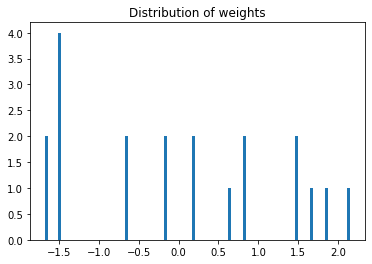

In [33]:
plt.hist(model.decoder.model[0].weight.detach().numpy()[:, :15].reshape(-1), bins=100)
plt.title("Distribution of weights")
plt.show()

Build the ground truth matrix

In [34]:
ground_truth_weight = np.zeros((n_observations, n_hidden))
for edge in results['data_graph'].graph.in_edges.data(nbunch=results['data_graph'].get_observation_nodes(), 
                                                      data='weight'):
    ground_truth_weight[edge[1]-n_hidden, edge[0]] = edge[2]


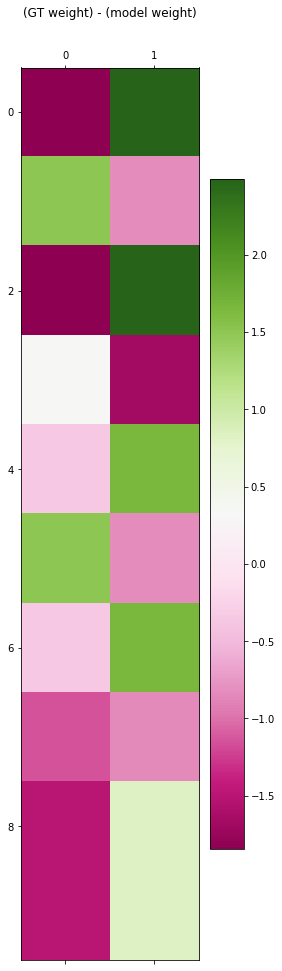

In [35]:
matrix_of_differences = ground_truth_weight - model.decoder.model[0].weight.detach().numpy()
plt.matshow(matrix_of_differences, cmap="PiYG")
plt.title("(GT weight) - (model weight)")
# plt.clim(vmin=-1, vmax=1)
plt.colorbar()
plt.show()

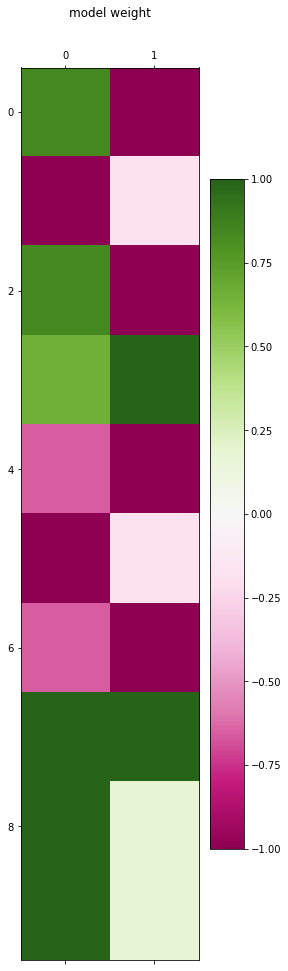

In [36]:
plt.matshow(model.decoder.model[0].weight.detach().numpy(), cmap="PiYG")
plt.title("model weight")
plt.clim(vmin=-1, vmax=1)
plt.colorbar()
plt.show()

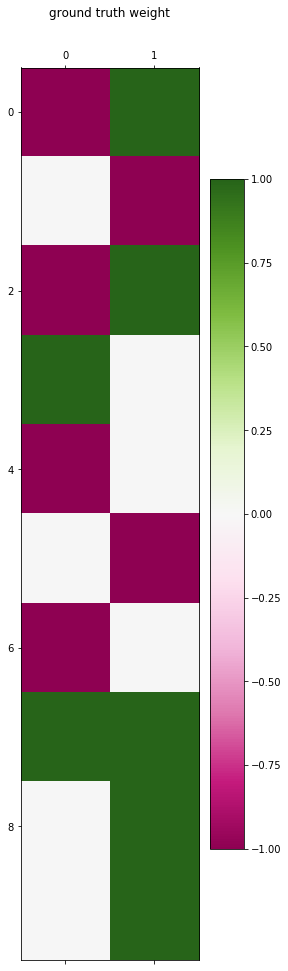

In [37]:
plt.matshow(ground_truth_weight, cmap="PiYG")
plt.title("ground truth weight")
# plt.clim(vmin=-1, vmax=1)
plt.colorbar()
plt.show()

In [38]:
theta = 2

In [39]:
rot = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

In [40]:
def cosine_dist(A, B):
    """
    Compute the sum of cosine distances between the rows of A and B
    """
    dist = 0
    for i in range(len(ground_truth_weight)):
        dist += cosine(A[i], B[i])
    return dist

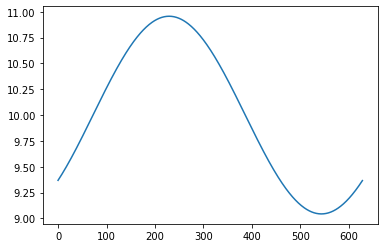

In [41]:
dist_to_ground_truth = []
for theta in np.arange(0, 2*np.pi, 0.01):
    rot = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    rotated_weights = model.decoder.model[0].weight.detach().numpy().dot(rot)
    dist_to_ground_truth.append(cosine_dist(rotated_weights, ground_truth_weight))

plt.plot(dist_to_ground_truth)
plt.show()

## Ground Truth Autoencoder
Comparing real latent variables with infered ones

In [31]:
u, s, vh = svd(ground_truth_weight)

In [32]:
u.shape, s.shape, vh.shape

((10, 10), (2,), (2, 2))

In [33]:
u[:, :len(s)].dot(np.diag(s)).dot(vh)

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 0., -1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0., -1.],
       [ 0., -1.],
       [ 0., -1.],
       [ 1.,  0.]])

In [34]:
ground_truth_weight

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 0., -1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0., -1.],
       [ 0., -1.],
       [ 0., -1.],
       [ 1.,  0.]])

In [35]:
vh.T

array([[-0., -1.],
       [-1., -0.]])

In [36]:
G_inv = vh.T.dot(np.diag(1/s)).dot(u.T[:len(s), :])

In [37]:
ground_truth_weight

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 0., -1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0., -1.],
       [ 0., -1.],
       [ 0., -1.],
       [ 1.,  0.]])

In [38]:
G_inv

array([[ 0.25      ,  0.25      ,  0.        ,  0.25      ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.25      ],
       [ 0.        ,  0.        , -0.16666667,  0.        ,  0.16666667,
         0.16666667, -0.16666667, -0.16666667, -0.16666667,  0.        ]])

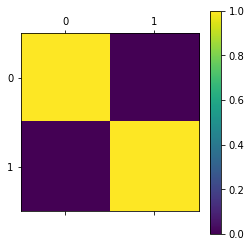

In [39]:
plt.matshow(G_inv.dot(ground_truth_weight))
plt.colorbar()
plt.show()

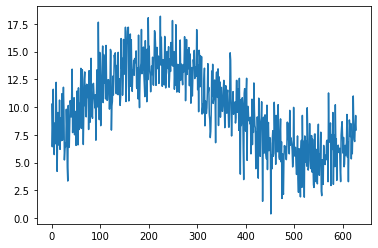

In [40]:
dist_to_ground_truth = []
for theta in np.arange(0, 2*np.pi, 0.01):
    rot = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    with torch.no_grad():
        for batch_idx, data in enumerate(valid_loader):

            x, fingerprint, compound, line = data

            # Expected to return a dictionary of outputs.
            outputs = model.forward(x, fingerprint, compound, line)

            real_z = x.numpy().dot(G_inv.T)
            dist_to_ground_truth.append(cosine_dist(outputs['z'].numpy().dot(rot), real_z))
            break
            
plt.plot(dist_to_ground_truth)
plt.show()